<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/fast_local_shading_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial focuses on the fast local shading mode of redner. This mode does not compute shadow or global illumination, but is faster and less noisy.

Again, we will import pyredner and tensorflow, download the teapot object, load it, and setup the camera.

In [1]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 66.9MB/s 
  Found existing installation: redner-gpu 0.1.24
    Uninstalling redner-gpu-0.1.24:
      Successfully uninstalled redner-gpu-0.1.24


In [2]:
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution() # redner only supports eager mode
import pyredner_tensorflow as pyredner

TensorFlow 2.x selected.


In [0]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/common/model/teapot/teapot.zip', 'teapot.zip')
# unzip
zip_ref = zipfile.ZipFile('teapot.zip', 'r')
zip_ref.extractall('teapot/')

In [0]:
objects = pyredner.load_obj('teapot/teapot.obj', return_objects=True)

In [0]:
camera = pyredner.automatic_camera_placement(objects, resolution=(480, 640))

In [0]:
scene = pyredner.Scene(camera = camera, objects = objects)

Now, in contrast to the previous tutorials, we also setup some lightings. In the fast local shading mode, redner supports four kinds of lights: ambient light, point light, directional light, and spot light. We setup a point light with squared distance falloff at between the camera and the teapot this time.

In [0]:
light = pyredner.PointLight(position = camera.position + tf.constant((0.0, 0.0, 100.0)),
                                                intensity = tf.constant((20000.0, 30000.0, 20000.0)))

Scene construction, time: 21.46748 s
Forward pass, time: 0.08253 s


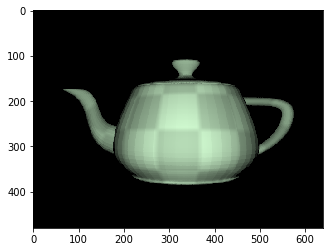

In [8]:
img = pyredner.render_deferred(scene = scene, lights = [light])
# Visualize img
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(tf.pow(img, 1.0/2.2))

You may notice that the teapot rendering has some weird stripe patterns. This is because the teapot has a low number of polygons, and the normals used to calculate the Lambertian response introduces the pattern to rendering. A remedy for this is to use [Phong normal interpolation](https://en.wikipedia.org/wiki/Phong_shading): we compute a normal field at each vertex on the triangle mesh, and interpolate from the nearby vertices when computing the shading normal. Many Wavefront object files come with vertex normals, but this teapot does not. Redner implements [Nelson Max's algorithm](https://escholarship.org/content/qt7657d8h3/qt7657d8h3.pdf?t=ptt283) for computing the vertex normal. We can attach vertex normals as follows:

In [0]:
for obj in objects:
    obj.normals = pyredner.compute_vertex_normal(obj.vertices, obj.indices)

Re-render the scene, we get a smoother teapot:

Scene construction, time: 0.00882 s
Forward pass, time: 0.08277 s


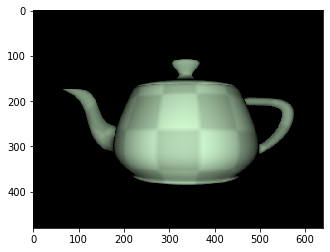

In [10]:
scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_deferred(scene = scene, lights = [light])
imshow(tf.pow(img, 1.0/2.2))

Apart from point lights, redner also supports ambient light, which is just a multiplier over the albedo values.

Scene construction, time: 0.00929 s
Forward pass, time: 0.08020 s


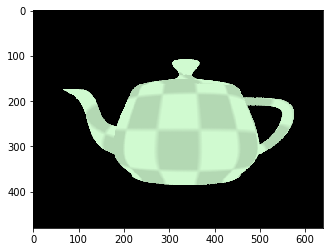

In [11]:
light = pyredner.AmbientLight(intensity = tf.constant((0.8, 1.2, 0.8)))
img = pyredner.render_deferred(scene = scene, lights = [light])
imshow(tf.pow(img, 1.0/2.2))

Directional lights doesn't exhibit distance falloff:

Scene construction, time: 0.00961 s
Forward pass, time: 0.08078 s


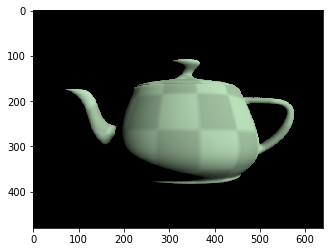

In [12]:
light = pyredner.DirectionalLight(direction = tf.constant((1.0, -1.0, 1.0)),
                                                         intensity = tf.constant((2.0, 3.0, 2.0)))
img = pyredner.render_deferred(scene = scene, lights = [light])
imshow(tf.pow(img, 1.0/2.2))

And spot light is a directional light with exponential falloff over a direction.

Scene construction, time: 0.00929 s
Forward pass, time: 0.08456 s


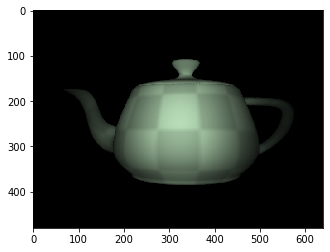

In [13]:
light = pyredner.SpotLight(position = camera.position,
                                               spot_direction = tf.constant((0.0, 0.0, 1.0)),
                                               spot_exponent = tf.constant(100.0),
                                               intensity = tf.constant((2.0, 3.0, 2.0)))
img = pyredner.render_deferred(scene = scene, lights = [light])
imshow(tf.pow(img, 1.0/2.2))

If you want to adapt the deferred shading functionality, such as using materials other than Lambertian, you can write the shading code yourself in TensorFlow. redner provides the `render_g_buffer` function to output different channels for you:

Scene construction, time: 0.04302 s
Forward pass, time: 0.02625 s


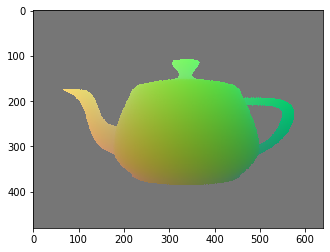

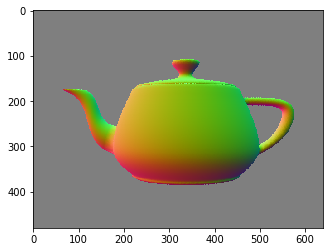

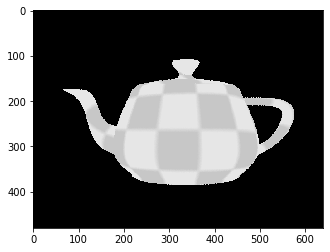

In [14]:
img = pyredner.render_g_buffer(scene = scene, channels = [pyredner.channels.position,
                                                                                                         pyredner.channels.shading_normal,
                                                                                                         pyredner.channels.diffuse_reflectance])
pos = img[:, :, :3]
normal = img[:, :, 3:6]
albedo = img[:, :, 6:9]
import matplotlib.pyplot as plt
plt.figure()
pos_vis = (pos - tf.reduce_min(pos)) / (tf.reduce_max(pos) - tf.reduce_min(pos))
imshow(pos_vis)
plt.figure()
normal_vis = (normal - tf.reduce_min(normal)) / (tf.reduce_max(normal) - tf.reduce_min(normal))
imshow(normal_vis)
plt.figure()
imshow(tf.pow(albedo, 1.0/2.2))

You can then write your own TensorFlow functions to assemble different channels. Antialising can be achieved using full-screen anti-aliasing (FSAA) -- just render the image at higher resolution then downsample it. See the source code of `render_g_buffer` to see how I did anti-aliasing.